<a href="https://colab.research.google.com/github/lescardone/deep-learning-project/blob/main/CNN_viz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.layers import MaxPooling2D, Conv2D, Flatten, Dense, Dropout
from keras.models import Sequential
from keras.optimizers import RMSprop, Adam

In [2]:
import os, shutil
from google.colab import drive
drive.mount('/content/grive')

Drive already mounted at /content/grive; to attempt to forcibly remount, call drive.mount("/content/grive", force_remount=True).


In [3]:
# Directories for our training,
# validation and test splits
base_dir = '/content/grive/My Drive/Metis/Deep-Learning/deep-learning-project/photos/small'

train_dir = os.path.join(base_dir, 'train')

validation_dir = os.path.join(base_dir, 'validation')

test_dir = os.path.join(base_dir, 'test')

In [4]:
# Directory with our training smiling pictures
train_happy_dir = os.path.join(train_dir, 'happy')
# os.mkdir(train_happy_dir)

# Directory with our training sad pictures
train_sad_dir = os.path.join(train_dir, 'sad')
# os.mkdir(train_sad_dir)

# Directory with our validation smiling pictures
validation_happy_dir = os.path.join(validation_dir, 'happy')
# os.mkdir(validation_happy_dir)

# Directory with our validation sad pictures
validation_sad_dir = os.path.join(validation_dir, 'sad')
# os.mkdir(validation_sad_dir)

# Directory with our validation smiling pictures
test_happy_dir = os.path.join(test_dir, 'happy')
# os.mkdir(test_happy_dir)

# Directory with our validation sad pictures
test_sad_dir = os.path.join(test_dir, 'sad')
# os.mkdir(test_sad_dir)

In [5]:
# !pip install --upgrade tf-keras-vis tensorflow matplotlib

In [21]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.mobilenet import preprocess_input
import numpy as np
import matplotlib.pyplot as plt

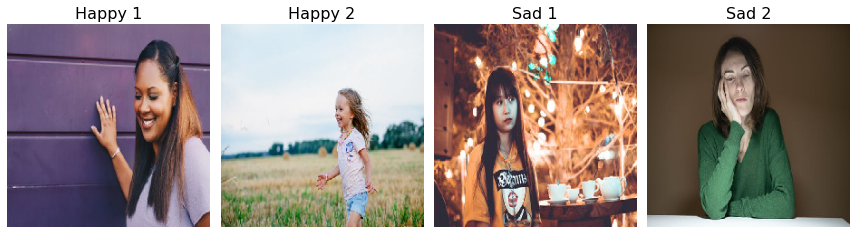

In [74]:
# Image titles
image_titles = ['Happy 1', 'Happy 2', 'Sad 1','Sad 2']

# Load images and Convert them to a Numpy array
img1 = load_img('./happy/happy_493.jpg', target_size=(224, 224))
img2 = load_img('./happy/happy_489.jpg', target_size=(224, 224))
img3 = load_img('./sad/sad_499.jpg', target_size=(224, 224))
img4 = load_img('./sad/sad_497.jpg', target_size=(224, 224))
images = np.asarray([np.array(img1), np.array(img2), np.array(img3), np.array(img4)])

# Preparing input data for MobileNet
X = preprocess_input(images)

# Rendering
f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].axis('off')
plt.tight_layout()
plt.savefig('./preprocessed.png')
plt.show()

In [23]:
def model_modifier(cloned_model):
    cloned_model.layers[-1].activation = tf.keras.activations.linear
    return cloned_model

In [75]:
from tf_keras_vis.utils.scores import CategoricalScore

score = CategoricalScore([981, 981, 982, 982])

In [76]:
from tensorflow.keras.applications import MobileNet
conv_mobile = MobileNet(weights='imagenet',
                        include_top=True,
                        input_shape=(224,224,3))
conv_mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

In [78]:
from tf_keras_vis.activation_maximization import ActivationMaximization
import tensorflow as tf
from tf_keras_vis.utils import num_of_gpus

_, gpus = num_of_gpus()
print('Tensorflow recognized {} GPUs'.format(gpus))

activation_maximization = ActivationMaximization(conv_mobile,
                                                 model_modifier,
                                                 clone=False)

Tensorflow recognized 0 GPUs


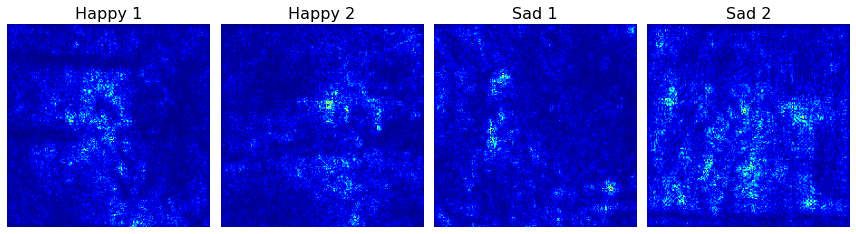

CPU times: user 2.22 s, sys: 297 ms, total: 2.52 s
Wall time: 1.79 s


In [79]:
%%time
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize

# Create Saliency object.
saliency = Saliency(conv_mobile,
                    model_modifier=model_modifier,
                    clone=False)

# Generate saliency map
saliency_map = saliency(score, seed_input=X)

# Render
f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(saliency_map[i], cmap='jet')
    ax[i].axis('off')
plt.tight_layout()
plt.show()

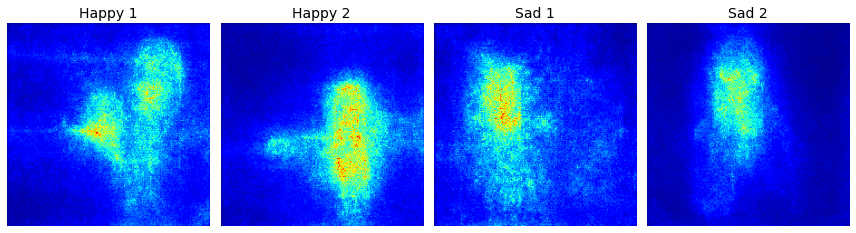

CPU times: user 26.8 s, sys: 2.19 s, total: 29 s
Wall time: 18.4 s


In [80]:

%%time

# Generate saliency map with smoothing that reduce noise by adding noise
saliency_map = saliency(score,
                        X,
                        smooth_samples=20, # The number of calculating gradients iterations.
                        smooth_noise=0.20) # noise spread level.

# Render
f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(saliency_map[i], cmap='jet')
    ax[i].axis('off')
plt.tight_layout()
plt.savefig('./smoothgrad.png')
plt.show()

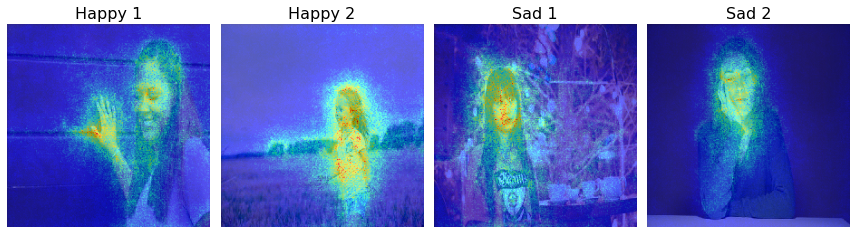

In [81]:

import cv2
from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam

# Create Gradcam object
gradcam = Gradcam(conv_mobile,
                  model_modifier=model_modifier,
                  clone=False)

# Generate heatmap with GradCAM
cam = gradcam(score, X, penultimate_layer=-1)

# Render
f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].imshow(saliency_map[i], cmap='jet', alpha=0.6) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.savefig('./gradcam.png')
plt.show()

In [8]:
#creating a mapping of layer name ot layer details 
#we will create a dictionary layers_info which maps a layer name to its charcteristics
layers_info = {}
for i in conv_mobile.layers:
    layers_info[i.name] = i.get_config()

#here the layer_weights dictionary will map every layer_name to its corresponding weights
layer_weights = {}
for i in conv_mobile.layers:
    layer_weights[i.name] = i.get_weights()

layers_info['conv_pw_13']

{'activation': 'linear',
 'activity_regularizer': None,
 'bias_constraint': None,
 'bias_initializer': {'class_name': 'Zeros', 'config': {}},
 'bias_regularizer': None,
 'data_format': 'channels_last',
 'dilation_rate': (1, 1),
 'dtype': 'float32',
 'filters': 1024,
 'groups': 1,
 'kernel_constraint': None,
 'kernel_initializer': {'class_name': 'GlorotUniform',
  'config': {'seed': None}},
 'kernel_regularizer': None,
 'kernel_size': (1, 1),
 'name': 'conv_pw_13',
 'padding': 'same',
 'strides': (1, 1),
 'trainable': True,
 'use_bias': False}

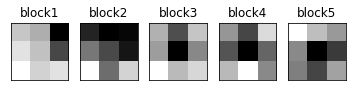

In [9]:
import matplotlib.pyplot as plt
layers = conv_mobile.layers
layer_ids = [1,4,11,17,24]
#plot the filters
fig,ax = plt.subplots(nrows=1,ncols=5)
for i in range(5):
    ax[i].imshow(layers[layer_ids[i]].get_weights()[0][:,:,:,0][:,:,0],cmap='gray')
    ax[i].set_title('block'+str(i+1))
    ax[i].set_xticks([])
    ax[i].set_yticks([])

In [63]:
layer_name = 'conv_pw_13'
def model_modifier(cloned_model):
    cloned_model.layers[-1].activation = tf.keras.activations.linear
    return cloned_model

In [64]:
from tf_keras_vis.activation_maximization import ActivationMaximization

activation_maximization = ActivationMaximization(conv_mobile,
                                                 model_modifier,
                                                 clone=False)

In [69]:
from tf_keras_vis.utils.scores import CategoricalScore

scores = CategoricalScore([981, 982, 981, 982])

Steps: 050	Scores: [[1.4972822666168213, 2.136129379272461, 2.0949549674987793, 1.918134093284607]],	Regularizations: [('TotalVariation2D', [1.6590304374694824, 1.6594406366348267, 1.6643973588943481, 1.6724270582199097]), ('Norm', [0.3259027302265167, 0.32673269510269165, 0.32743844389915466, 0.32624295353889465])]
Steps: 100	Scores: [[1.1809329986572266, 2.625216484069824, 1.8981943130493164, 2.630035161972046]],	Regularizations: [('TotalVariation2D', [1.612105369567871, 1.6042283773422241, 1.588661551475525, 1.5966150760650635]), ('Norm', [0.3248005211353302, 0.3253549337387085, 0.3259015381336212, 0.3245665729045868])]
Steps: 150	Scores: [[2.116813898086548, 2.3892064094543457, 2.3475027084350586, 3.0263185501098633]],	Regularizations: [('TotalVariation2D', [1.6365175247192383, 1.6392813920974731, 1.6190006732940674, 1.632836937904358]), ('Norm', [0.32390135526657104, 0.3240000903606415, 0.3251174986362457, 0.323076069355011])]
Steps: 200	Scores: [[2.6580541133880615, 2.29481720924

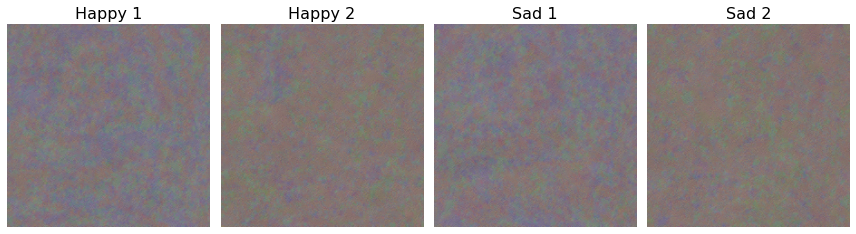

In [73]:
seed_input = tf.random.uniform((4, 224, 224, 3), 0, 255)
from tf_keras_vis.activation_maximization.callbacks import PrintLogger
from tf_keras_vis.activation_maximization.callbacks import GifGenerator2D

# Generate max activation
activations = activation_maximization(scores,
                                      seed_input=seed_input,
                                      steps=512,
                                      callbacks=[PrintLogger(interval=50)])

# Render
f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(activations[i])
    ax[i].axis('off')
plt.tight_layout()
plt.savefig('./visualize-dense-layer')
plt.show()